**Author Information**
* Barry Li: 
    * (redacted)
    * (redacted)
* Minzhe Feng: 
    * (redacted)
    * (redacted)

In [ ]:
!pip install pettingzoo
!pip install supersuit
!pip install rlcard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 43.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 629.0 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=325815 sha256=0ba399212facd7bafeb2fa2083049021aacef40851ace95a0587142cf22b1670
  Stored in directory: /root/.cache/pip/wheels/4a/07/41/111a95cc384eeb588bc42e1a0d0dd6fa642640adb5fdbc877e
Successfully built rlcard


In [ ]:
import itertools
from collections import defaultdict, namedtuple
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from rlcard import agents, make
from rlcard.agents.cfr_agent import CFRAgent
from rlcard.agents.dqn_agent import Memory
from rlcard.utils import get_device, reorganize, set_seed

# Agent Implementations

## Deep Monte Carlo CFR (Unsuccessful)

We tried both writing our own Deep Monte-Carlo CFR implementation and using the reference CFR agent from `rlcard`. Unfortunately, we were unsuccessful with our own attempt (see the last section), and the reference vanilla CFR agent turned out to be impractical in the Texas Hold'em environment, because the state space is way too large for the agent to perform exhaustive search on.

## Expected SARSA with softmax exploration

In [ ]:
class SARSAAgent(agents.RandomAgent):
    def __init__(
        self,
        discount_factor=0.99,
        batch_size=1,
        num_actions=4,
        state_shape=None,
        learning_rate=0.00005,
    ):
        super().__init__(num_actions)
        self.use_raw = False
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.Q = defaultdict(lambda: np.zeros(4))
        self.train_t = 0
        self.learning_rate = learning_rate

    def boltzmann(self, state, temp=0.5, action_size=4):
        pref_vector = self.Q["".join(str(x) for x in state)] / temp
        return np.exp(pref_vector)

    def update_exp(
        self, state, state_next, action, reward, alpha, temp=0.5, gamma=0.95
    ):
        state_str = "".join(str(x) for x in state_next["obs"])
        softmax = self.boltzmann(state_next)
        pi = softmax / softmax.sum()
        expected = (pi * self.Q[state_str]).sum()
        td = reward + gamma * expected - self.Q[state_str][action]
        self.Q[state_str][action] = self.Q[state_str][action] + alpha * td

    def feed(self, ts):
        self.train(ts)

    def step(self, state):
        action_probs = self.predict(state)
        legal_actions = list(state["legal_actions"].keys())
        np_legal = np.array(legal_actions)
        len(legal_actions)
        action_probs = action_probs[np_legal]
        sum_probs = np.sum(action_probs)
        probs = np.divide(action_probs, sum_probs)
        action_idx = np.random.choice(np.arange(len(probs)), p=probs)

        return legal_actions[action_idx]

    def eval_step(self, state):
        q_values = self.predict(state)
        best_action = np.argmax(q_values)

        info = {}
        info["values"] = {
            state["raw_legal_actions"][i]: float(
                q_values[list(state["legal_actions"].keys())[i]]
            )
            for i in range(len(state["legal_actions"]))
        }

        return best_action, info

    def predict(self, state):
        # TODO: Figure out the dimentionality settings
        q_values = self.boltzmann(state["obs"])
        masked_q_values = -np.inf * np.ones(self.num_actions, dtype=float)
        legal_actions = list(state["legal_actions"].keys())
        masked_q_values[legal_actions] = q_values[legal_actions]

        return masked_q_values

    def train(self, ts):
        (state, action, reward, next_state, done) = tuple(ts)
        self.update_exp(state, next_state, action, reward, self.learning_rate)

## Dueling Double DQN with epsilon greedy action exploration

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, num_actions=2, state_shape=None, device=None):
        super(DuelingDQN, self).__init__()
        self.num_actions = num_actions
        self.state_shape = state_shape
        self.device = device

        self.feauture_layer = nn.Sequential(
            nn.Linear(self.state_shape[0], 64),
            nn.ReLU(),
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, self.num_actions)
        )

    def forward(self, state):
        features = self.feauture_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals

In [ ]:
class QEstimator(object):
    """
    Approximate clone of rlcard.agents.dqn_agent.Estimator that
    uses PyTorch instead of Tensorflow.  All methods input/output np.ndarray.
    Q-Value Estimator neural network.
    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(
        self, num_actions=2, learning_rate=0.001, state_shape=None, device=None
    ):
        """Initilalize an Estimator object.
        Args:
            num_actions (int): the number output actions
            state_shape (list): the shape of the state space
            device (torch.device): whether to use cpu or gpu
        """
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.state_shape = state_shape
        self.device = device

        # set up Q model and place it in eval mode
        qnet = DuelingDQN(num_actions, state_shape, device)
        qnet = qnet.to(self.device)
        self.qnet = qnet
        self.qnet.eval()

        # initialize the weights using Xavier init
        for p in self.qnet.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        # set up loss function
        self.mse_loss = nn.MSELoss(reduction="mean")

        # set up optimizer
        self.optimizer = torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)

    def predict_nograd(self, s):
        """Predicts action values, but prediction is not included
            in the computation graph.  It is used to predict optimal next
            actions in the Double-DQN algorithm.
        Args:
          s (np.ndarray): (batch, state_len)
        Returns:
          np.ndarray of shape (batch_size, NUM_VALID_ACTIONS) containing the estimated
          action values.
        """
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.qnet(s).cpu().numpy()
        return q_as

    def update(self, s, a, y):
        """Updates the estimator towards the given targets.
            In this case y is the target-network estimated
            value of the Q-network optimal actions, which
            is labeled y in Algorithm 1 of Minh et al. (2015)
        Args:
          s (np.ndarray): (batch, state_shape) state representation
          a (np.ndarray): (batch,) integer sampled actions
          y (np.ndarray): (batch,) value of optimal actions according to Q-target
        Returns:
          The calculated loss on the batch.
        """
        self.optimizer.zero_grad()

        self.qnet.train()

        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        y = torch.from_numpy(y).float().to(self.device)

        # (batch, state_shape) -> (batch, num_actions)
        q_as = self.qnet(s)

        # (batch, num_actions) -> (batch, )
        Q = torch.gather(q_as, dim=-1, index=a.unsqueeze(-1)).squeeze(-1)

        # update model
        batch_loss = self.mse_loss(Q, y)
        batch_loss.backward()
        self.optimizer.step()
        batch_loss = batch_loss.item()

        self.qnet.eval()

        return batch_loss

In [ ]:
class DuelingDQNAgent(agents.RandomAgent):
    def __init__(
        self,
        replay_memory_size=20000,
        replay_memory_init_size=100,
        discount_factor=0.99,
        epsilon_start=1.0,
        epsilon_end=0.1,
        update_target_estimator_every=1000,
        epsilon_decay_steps=20000,
        batch_size=50,
        num_actions=2,
        state_shape=None,
        train_every=10,
        learning_rate=0.00005,
        device=None,
    ):
        super().__init__(num_actions)
        self.use_raw = False
        self.replay_memory_init_size = replay_memory_init_size
        self.update_target_estimator_every = update_target_estimator_every
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.num_actions = num_actions
        self.train_every = train_every
        # Torch device
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Total timesteps
        self.total_t = 0
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Total training step
        self.train_t = 0

        # Create duel dqn model
        self.model = QEstimator(
            num_actions=self.num_actions,
            learning_rate=learning_rate,
            state_shape=state_shape,
            device=self.device,
        )
        self.target_model = QEstimator(
            num_actions=self.num_actions,
            learning_rate=learning_rate,
            state_shape=state_shape,
            device=self.device,
        )
        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)
        # need feed,train,step,step_eval etc

    def feed(self, ts):
        """Store data in to replay buffer and train the agent. There are two stages.
            In stage 1, populate the memory without training
            In stage 2, train the agent every several timesteps
        Args:
            ts (list): a list of 5 elements that represent the transition
        """
        (state, action, reward, next_state, done) = tuple(ts)
        self.feed_memory(
            state["obs"],
            action,
            reward,
            next_state["obs"],
            list(next_state["legal_actions"].keys()),
            done,
        )
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp >= 0 and tmp % self.train_every == 0:
            self.train()

    def feed_memory(self, state, action, reward, next_state, legal_actions, done):
        self.memory.save(state, action, reward, next_state, legal_actions, done)

    def step(self, state):
        """Predict the action for genrating training data but
            have the predictions disconnected from the computation graph
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
        """
        q_values = self.predict(state)
        epsilon = self.epsilons[min(self.total_t, self.epsilon_decay_steps - 1)]
        legal_actions = list(state["legal_actions"].keys())
        probs = np.ones(len(legal_actions), dtype=float) * epsilon / len(legal_actions)
        best_action_idx = legal_actions.index(np.argmax(q_values))
        probs[best_action_idx] += 1.0 - epsilon
        action_idx = np.random.choice(np.arange(len(probs)), p=probs)

        return legal_actions[action_idx]

    def eval_step(self, state):
        """Predict the action for evaluation purpose.
        Args:
            state (numpy.array): current state
        Returns:
            action (int): an action id
            info (dict): A dictionary containing information
        """
        q_values = self.predict(state)
        best_action = np.argmax(q_values)

        info = {}
        info["values"] = {
            state["raw_legal_actions"][i]: float(
                q_values[list(state["legal_actions"].keys())[i]]
            )
            for i in range(len(state["legal_actions"]))
        }

        return best_action, info

    def predict(self, state):
        """Predict the masked Q-values
        Args:
            state (numpy.array): current state
        Returns:
            q_values (numpy.array): a 1-d array where each entry represents a Q value
        """

        q_values = self.model.predict_nograd(np.expand_dims(state["obs"], 0))[0]
        masked_q_values = -np.inf * np.ones(self.num_actions, dtype=float)
        legal_actions = list(state["legal_actions"].keys())
        masked_q_values[legal_actions] = q_values[legal_actions]

        return masked_q_values

    def train(self):
        """Train the network
        Returns:
            loss (float): The loss of the current batch.
        """
        (
            state_batch,
            action_batch,
            reward_batch,
            next_state_batch,
            done_batch,
            legal_actions_batch,
        ) = self.memory.sample()

        # Calculate best next actions using Q-network (Double DQN)

        # one of the following two lines is correct
        q_values_next = self.model.predict_nograd(next_state_batch)
        # q_values_next = self.target_model.predict_nograd(next_state_batch)
        legal_actions = []
        for b in range(self.batch_size):
            legal_actions.extend(
                [i + b * self.num_actions for i in legal_actions_batch[b]]
            )
        masked_q_values = -np.inf * np.ones(
            self.num_actions * self.batch_size, dtype=float
        )
        masked_q_values[legal_actions] = q_values_next.flatten()[legal_actions]
        masked_q_values = masked_q_values.reshape((self.batch_size, self.num_actions))
        best_actions = np.argmax(masked_q_values, axis=1)

        # Evaluate best next actions using Target-network (Double DQN)
        q_values_next_target = self.target_model.predict_nograd(next_state_batch)
        target_batch = (
            reward_batch
            + np.invert(done_batch).astype(np.float32)
            * self.discount_factor
            * q_values_next_target[np.arange(self.batch_size), best_actions]
        )

        # Perform gradient descent update
        state_batch = np.array(state_batch)

        self.model.update(state_batch, action_batch, target_batch)
        # print('\rINFO - Step {}, rl-loss: {}'.format(self.total_t, loss), end='')

        # Update the target estimator
        if self.train_t % self.update_target_estimator_every == 0:
            self.target_model = deepcopy(self.model)
            # print("\nINFO - Copied model parameters to target network.")

        self.train_t += 1

## A2C with softmax exploration

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, num_actions=2, state_shape=None, device=None):
        super(ActorNetwork, self).__init__()
        self.num_actions = num_actions
        self.state_shape = state_shape
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, num_actions),
            nn.Softmax(dim=-1),
        )

    def forward(self, state):
        return self.model(state)


class CriticNetwork(nn.Module):
    def __init__(self, state_shape=None, device=None):
        super(CriticNetwork, self).__init__()
        self.state_shape = state_shape
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, state):
        return self.model(state)

In [ ]:
class ACEstimator(object):
    def __init__(
        self, num_actions=2, learning_rate=0.001, state_shape=None, device=None
    ):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.state_shape = state_shape
        self.device = device

        # set up Q model and place it in eval mode
        actor = ActorNetwork(num_actions, state_shape, device)
        actor = actor.to(self.device)
        self.actor = actor
        critic = CriticNetwork(state_shape, device)
        critic = critic.to(self.device)
        self.critic = critic
        self.actor.eval()
        self.critic.eval()

        # initialize the weights using Xavier init
        for p in self.actor.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        for p in self.critic.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        # set up optimizer
        self.actor_optimizer = torch.optim.Adam(
            self.actor.parameters(), lr=self.learning_rate
        )
        self.critic_optimizer = torch.optim.Adam(
            self.critic.parameters(), lr=self.learning_rate
        )

    def predict_nograd(self, s):
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.actor(s).cpu().numpy()
        return q_as

    def predict_critic(self, s):
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.critic(s).cpu().numpy()
        return q_as

    def update(self, state, actions, advantage_batch):
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        self.actor.train()
        self.critic.train()

        s = torch.from_numpy(state).float().to(self.device)
        a = torch.from_numpy(actions).long().to(self.device)
        y = torch.from_numpy(advantage_batch).float().to(self.device)

        action_probs = self.actor(s)
        action_log_probs = torch.log(
            torch.gather(action_probs, dim=-1, index=a.unsqueeze(-1)).squeeze(-1)
        )
        actor_loss = -torch.mean(action_log_probs * y.detach())
        critic_loss = torch.mean(y.pow(2))
        critic_loss.requires_grad_(True)
        # print(actor_loss)
        # update the actor parameters
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the critic parameters
        critic_loss.backward()
        self.critic_optimizer.step()

        # for logging
        actor_loss = actor_loss.item()
        critic_loss = critic_loss.item()

        self.actor.eval()
        self.critic.eval()

        return actor_loss, critic_loss

In [ ]:
class A2CAgent(agents.RandomAgent):
    def __init__(
        self,
        replay_memory_size=20000,
        replay_memory_init_size=100,
        discount_factor=0.99,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay_steps=20000,
        batch_size=50,
        num_actions=2,
        state_shape=None,
        train_every=10,
        learning_rate=0.00005,
        device=None,
    ):
        super().__init__(num_actions)
        self.use_raw = False
        self.replay_memory_init_size = replay_memory_init_size
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.num_actions = num_actions
        self.train_every = train_every
        # Torch device
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Total timesteps
        self.total_t = 0
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Total training step
        self.train_t = 0

        # Create AC model
        self.model = ACEstimator(
            num_actions=self.num_actions,
            learning_rate=learning_rate,
            state_shape=state_shape,
            device=self.device,
        )
        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)
        # need feed,train,step,step_eval etc

    def feed(self, ts):
        (state, action, reward, next_state, done) = tuple(ts)
        self.feed_memory(
            state["obs"],
            action,
            reward,
            next_state["obs"],
            list(next_state["legal_actions"].keys()),
            done,
        )
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp >= 0 and tmp % self.train_every == 0:
            self.train()

    def feed_memory(self, state, action, reward, next_state, legal_actions, done):
        self.memory.save(state, action, reward, next_state, legal_actions, done)

    # fix to softmax
    def step(self, state):
        action_probs = self.predict(state)
        legal_actions = list(state["legal_actions"].keys())
        np_legal = np.array(legal_actions)
        len(legal_actions)
        action_probs = action_probs[np_legal]
        sum_probs = np.sum(action_probs)
        probs = np.divide(action_probs, sum_probs)
        action_idx = np.random.choice(np.arange(len(probs)), p=probs)

        return legal_actions[action_idx]

    def eval_step(self, state):
        q_values = self.predict(state)
        best_action = np.argmax(q_values)

        info = {}
        info["values"] = {
            state["raw_legal_actions"][i]: float(
                q_values[list(state["legal_actions"].keys())[i]]
            )
            for i in range(len(state["legal_actions"]))
        }

        return best_action, info

    def predict(self, state):
        q_values = self.model.predict_nograd(np.expand_dims(state["obs"], 0))[0]
        masked_q_values = -np.inf * np.ones(self.num_actions, dtype=float)
        legal_actions = list(state["legal_actions"].keys())
        masked_q_values[legal_actions] = q_values[legal_actions]

        return masked_q_values

    # need fix
    def train(self):
        (
            state_batch,
            action_batch,
            reward_batch,
            next_state_batch,
            done_batch,
            legal_actions_batch,
        ) = self.memory.sample()

        # action_probs = self.model.predict_nograd(state_batch)
        state_value = self.model.predict_critic(state_batch).squeeze()
        next_state_value = self.model.predict_critic(next_state_batch).squeeze()

        returns = (
            reward_batch
            + np.invert(done_batch).astype(np.float32)
            * self.discount_factor
            * next_state_value
        )
        # might need to [np.arange(self.batch_size), best_actions] for next)state_value and state_value
        # Calculate the advantage
        advantage = returns - state_value

        # Perform gradient descent update
        state_batch = np.array(state_batch)

        aloss, closs = self.model.update(state_batch, action_batch, advantage)
        # print('\rINFO - Step {}, a-loss: {}, c-loss: {}'.format(self.total_t, aloss,closs), end='')

        # if self.train_t % 1000 == 0 and self.train_t != 0:
        #   print("\nINFO - Log and Continue")

        self.train_t += 1

# Training

In [ ]:
def training_script(agents, training_index, episodes):
    """
    agents: A list of agent to train length = 3
    training_index: A list of integer consisting of the index of agents that need to be trained length < 4
    """
    get_device()
    set_seed(579)

    # Train with agents
    num_players = len(agents)
    env = make("limit-holdem", config={"seed": 0, "game_num_players": num_players})
    env.set_agents(agents)
    for epi in range(episodes):
        trajectories, payoffs = env.run(is_training=True)
        trajectories = reorganize(trajectories, payoffs)
        for agent_index in training_index:
            agent = agents[agent_index]
            for ts in trajectories[agent_index]:
                agent.feed(ts)
    return agents


def training_cfr(agent, episodes):
    set_seed(579)
    for epi in range(episodes):
        agent.train()

In [ ]:
def testing_script(agents,episodes):
    set_seed(579)

    num_players = len(agents)
    env = make("limit-holdem", config={"seed": 0, "game_num_players": num_players})
    env.set_agents(agents)
    per_ep_payoffs = []
    for epi in range(episodes):
        _, payoffs = env.run(is_training=False)
        per_ep_payoffs.append(payoffs)
    return np.array(per_ep_payoffs)

In [ ]:
# An util function to plot the cumulative payoff for every order of play and
# the cululative average payoff of every agent for each position in the order of play
def cum_payoff_plots(agents, labels):
    first_to_play = {"A2C": [], "Expected SARSA": [], "Dueling DQN": []}
    second_to_play = {"A2C": [], "Expected SARSA": [], "Dueling DQN": []}
    third_to_play = {"A2C": [], "Expected SARSA": [], "Dueling DQN": []}

    figs, axes = plt.subplots(3, 2, figsize=(15, 15))
    agent_permutation = list(itertools.permutations(agents))
    label_permutation = list(
        itertools.permutations(["A2C", "Expected SARSA", "Dueling DQN"])
    )
    for i in range(6):
        ep_final = testing_script(agent_permutation[i], 5000)
        first_to_play[label_permutation[i][0]].append(ep_final[:, 0])
        second_to_play[label_permutation[i][1]].append(ep_final[:, 1])
        third_to_play[label_permutation[i][2]].append(ep_final[:, 2])
        cum_final = pd.DataFrame(
            np.array(ep_final), columns=label_permutation[i]
        ).cumsum()
        sns.lineplot(data=cum_final, ax=axes[i // 2][i % 2])
        axes[i // 2][i % 2].set_title(f"Player Order = {label_permutation[i]}")
    figs.supxlabel("Game")
    figs.supylabel("Cumulative Payoff")
    plt.show()

    figs, axes = plt.subplots(3, 1, figsize=(15, 15))
    figs.supxlabel("Game")
    figs.supylabel("Cumulative Average Payoff")
    for i, position in enumerate([first_to_play, second_to_play, third_to_play]):
        avg = {
            "A2C": ((position["A2C"][0] + position["A2C"][1]) / 2).cumsum(),
            "Expected SARSA": (
                (position["Expected SARSA"][0] + position["Expected SARSA"][1]) / 2
            ).cumsum(),
            "Dueling DQN": (
                (position["Dueling DQN"][0] + position["Dueling DQN"][1]) / 2
            ).cumsum(),
        }
        sns.lineplot(avg, ax=axes[i])
        num = ("first", "second", "third")
        axes[i].set_title(
            f"Cumulative average payoff when the agent is the {num[i]} to play"
        )
    plt.show()

In [ ]:
device = get_device()

--> Running on the GPU


## Train Against Random Agents

### CFR (Unsuccessful)

In [ ]:
# cfr_ar = CFRAgent(
#     env=make(
#         "limit-holdem",
#         config={"seed": 0, "game_num_players": 3, "allow_step_back": True},
#     )
# )
# agents_cfr_ar = [cfr_ar]
# for _ in range(1, 3):
#     agents_cfr_ar.append(agents.RandomAgent(num_actions=4))

In [ ]:
# Too slow
# training_cfr(cfr_ar, 1)

### Expected SARSA

In [ ]:
sarsa_ar = SARSAAgent()
agents_sarsa_ar = [sarsa_ar]
for _ in range(1, 3):
    agents_sarsa_ar.append(agents.RandomAgent(num_actions=4))

In [ ]:
training_script(agents_sarsa_ar,[0], 40000)

--> Running on the GPU


In [ ]:
dd_sarsa_ep = testing_script(agents_sarsa_ar, 5000)

In [ ]:
data_sarsa_ar_ep = pd.DataFrame(
    np.array(dd_sarsa_ep), columns=["Expected SARSA", "Random 1", "Random 2"]
).cumsum()

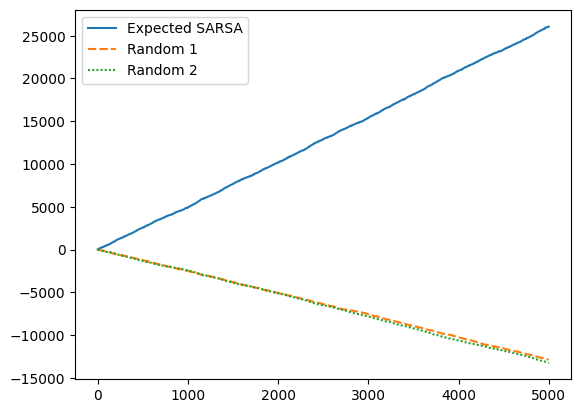

In [ ]:
sns.lineplot(data=data_sarsa_ar_ep)
plt.show()

### Dueling Double DQN

In [ ]:
dd_ar = DuelingDQNAgent(
    num_actions=4,
    state_shape=[72],
    device=device,
)
agents_dd_ar = [dd_ar]
for _ in range(1, 3):
    agents_dd_ar.append(agents.RandomAgent(num_actions=4))

In [ ]:
training_script(agents_dd_ar,[0], 40000)

--> Running on the GPU


In [ ]:
dd_ar_ep = testing_script(agents_dd_ar, 5000)

In [ ]:
data_dd_ar_ep = pd.DataFrame(
    np.array(dd_ar_ep), columns=["Dueling DQN", "Random 1", "Random 2"]
).cumsum()

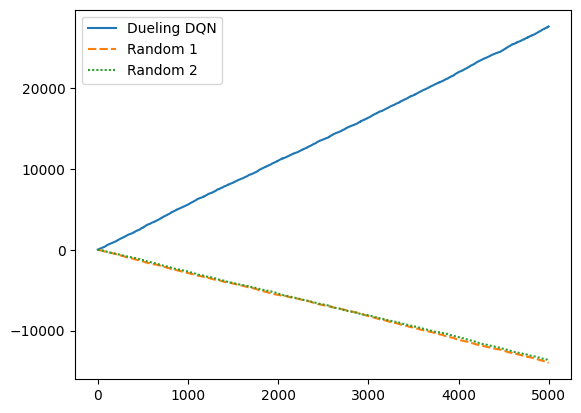

In [ ]:
sns.lineplot(data=data_dd_ar_ep)
plt.show()

### A2C

In [ ]:
a2c_ar = A2CAgent(
    num_actions=4,
    state_shape=[72],
    device=device,
)
agents_a2c_ar = [a2c_ar]
for _ in range(1, 3):
    agents_a2c_ar.append(agents.RandomAgent(num_actions=4))

In [ ]:
training_script(agents_a2c_ar,[0],40000)

--> Running on the GPU


In [ ]:
a2c_ar_ep = testing_script(agents_a2c_ar,5000)

In [ ]:
data_a2c_ar_ep = pd.DataFrame(
    np.array(a2c_ar_ep), columns=["A2C", "Random 1", "Random 2"]
).cumsum()

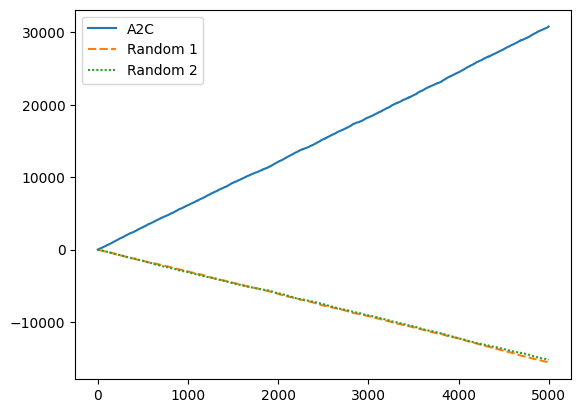

In [ ]:
sns.lineplot(data=data_a2c_ar_ep)
plt.show()

### Stage the three against one another

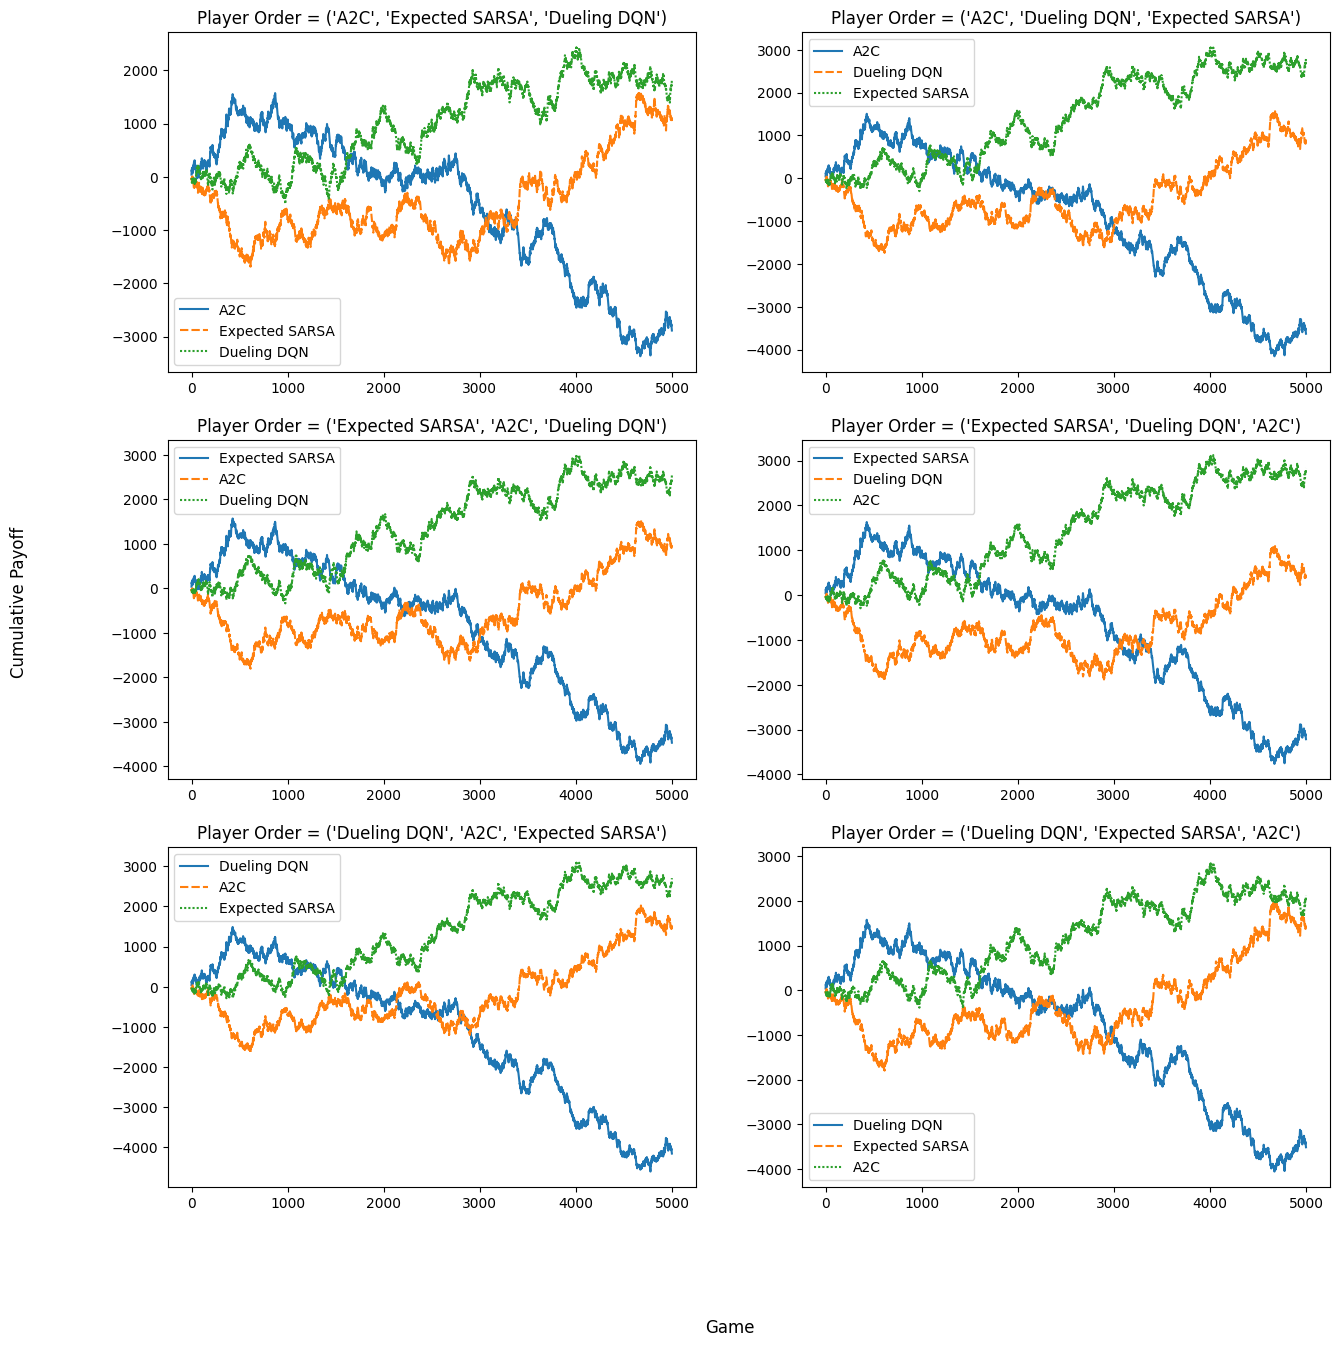

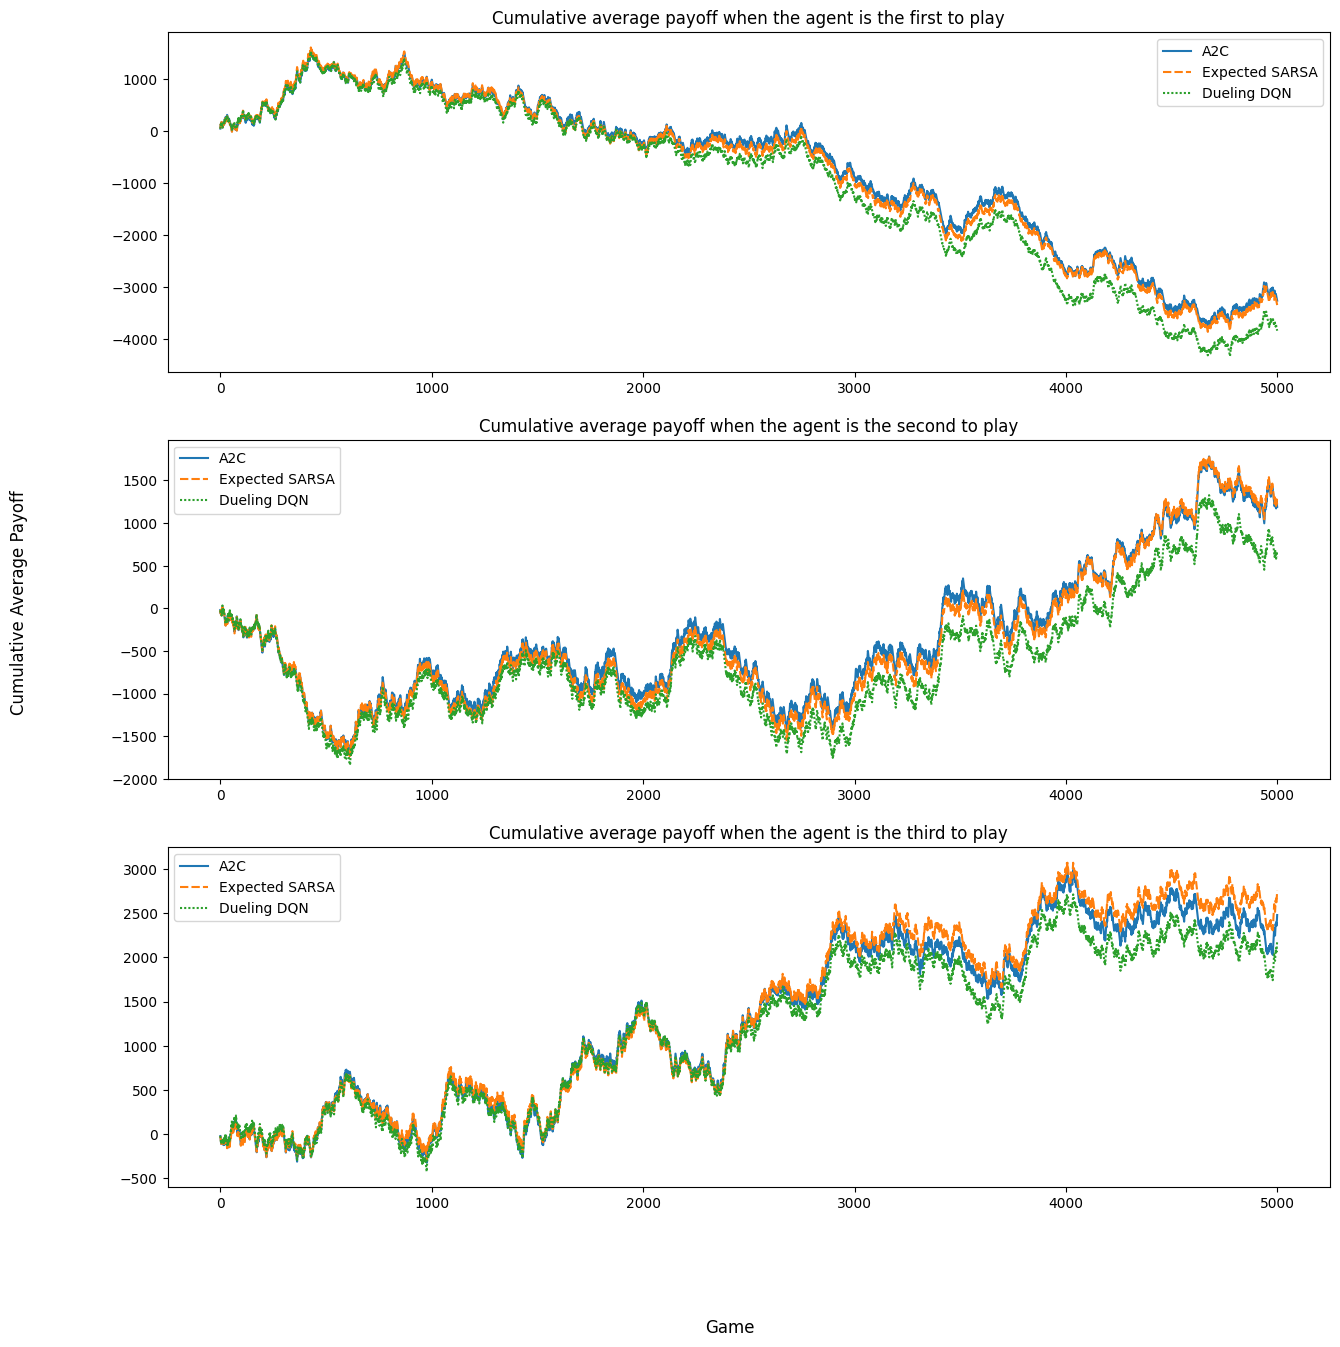

In [ ]:
cum_payoff_plots([a2c_ar, sarsa_ar, dd_ar], ["A2C", "Expected SARSA", "Dueling DQN"])

## Train Against Each Other

In [ ]:
dd_eo = DuelingDQNAgent(num_actions=4, state_shape=[72], device=device)
a2c_eo = A2CAgent(num_actions=4, state_shape=[72], device=device)
sarsa_eo = SARSAAgent()
agents_eo = [a2c_eo, sarsa_eo, dd_eo]

In [ ]:
training_script(agents_eo, [0, 1, 2], 40000)

--> Running on the GPU


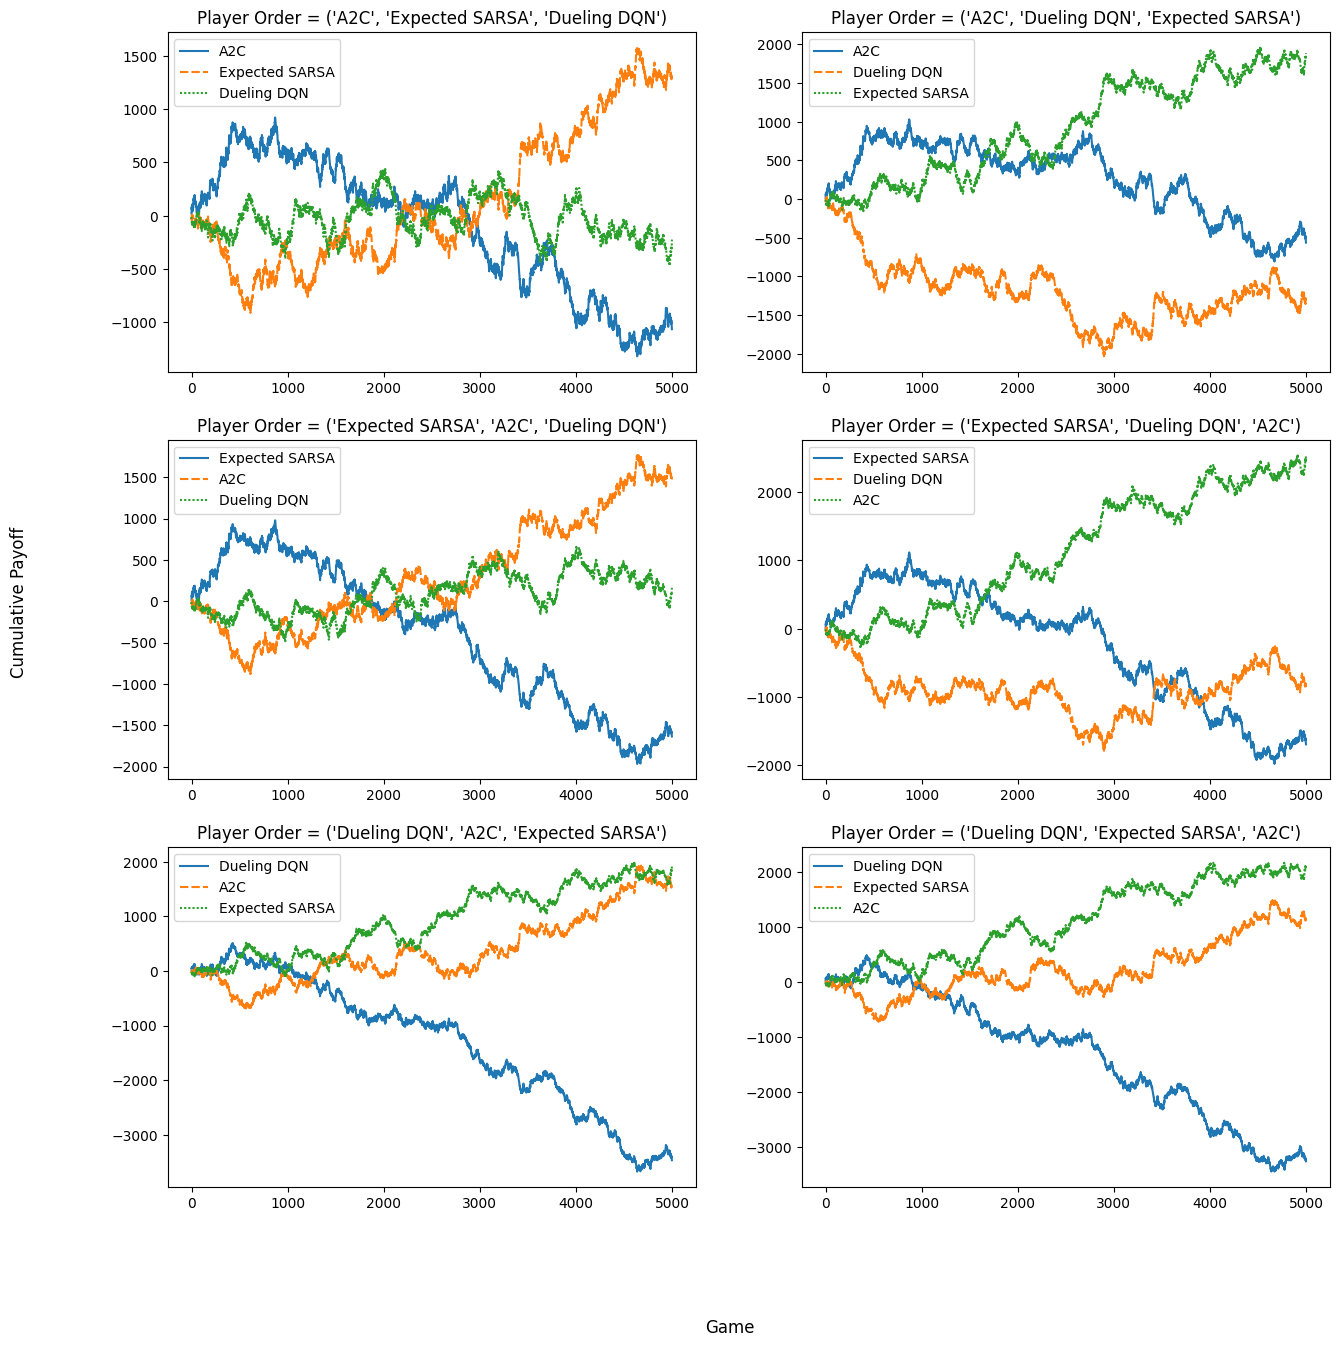

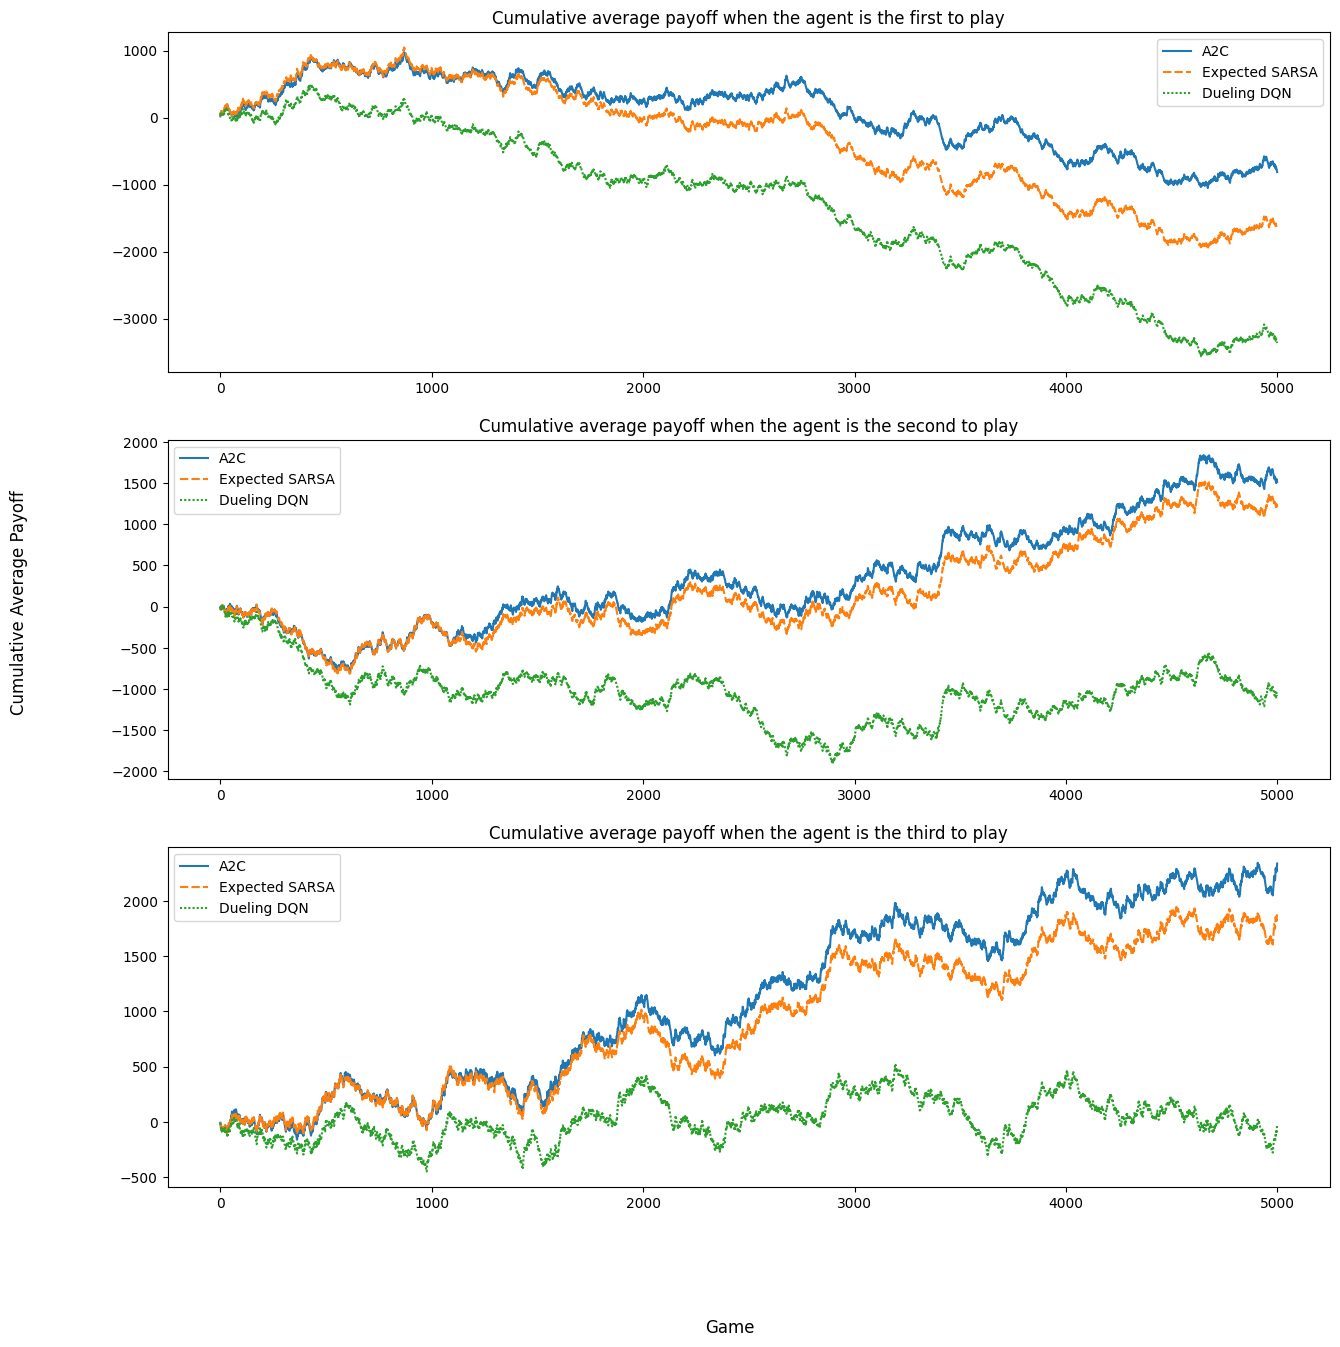

In [ ]:
cum_payoff_plots(agents_eo, ["A2C", "Expected SARSA", "Dueling DQN"])

## Train Against All Random + Each Other

In [ ]:
agents_ar_eo = [deepcopy(a2c_ar), deepcopy(sarsa_ar), deepcopy(dd_ar)]

In [ ]:
training_script(agents_ar_eo, [0, 1, 2], 40000)

--> Running on the GPU


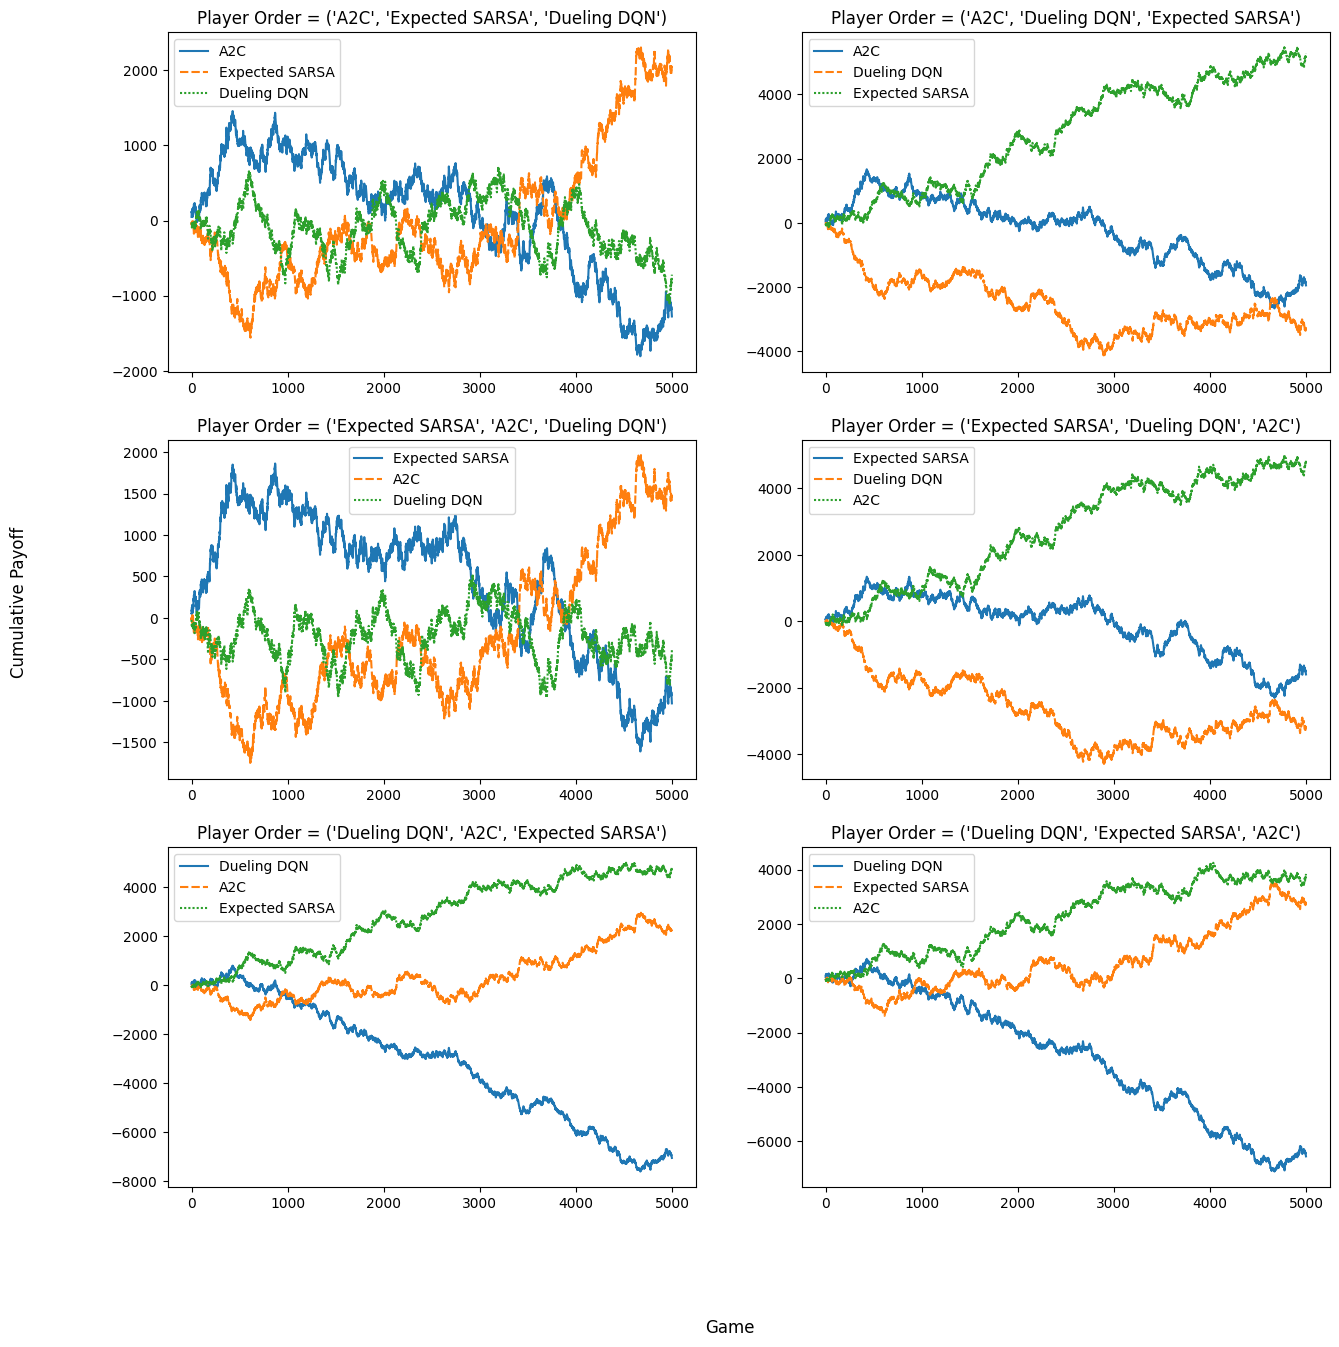

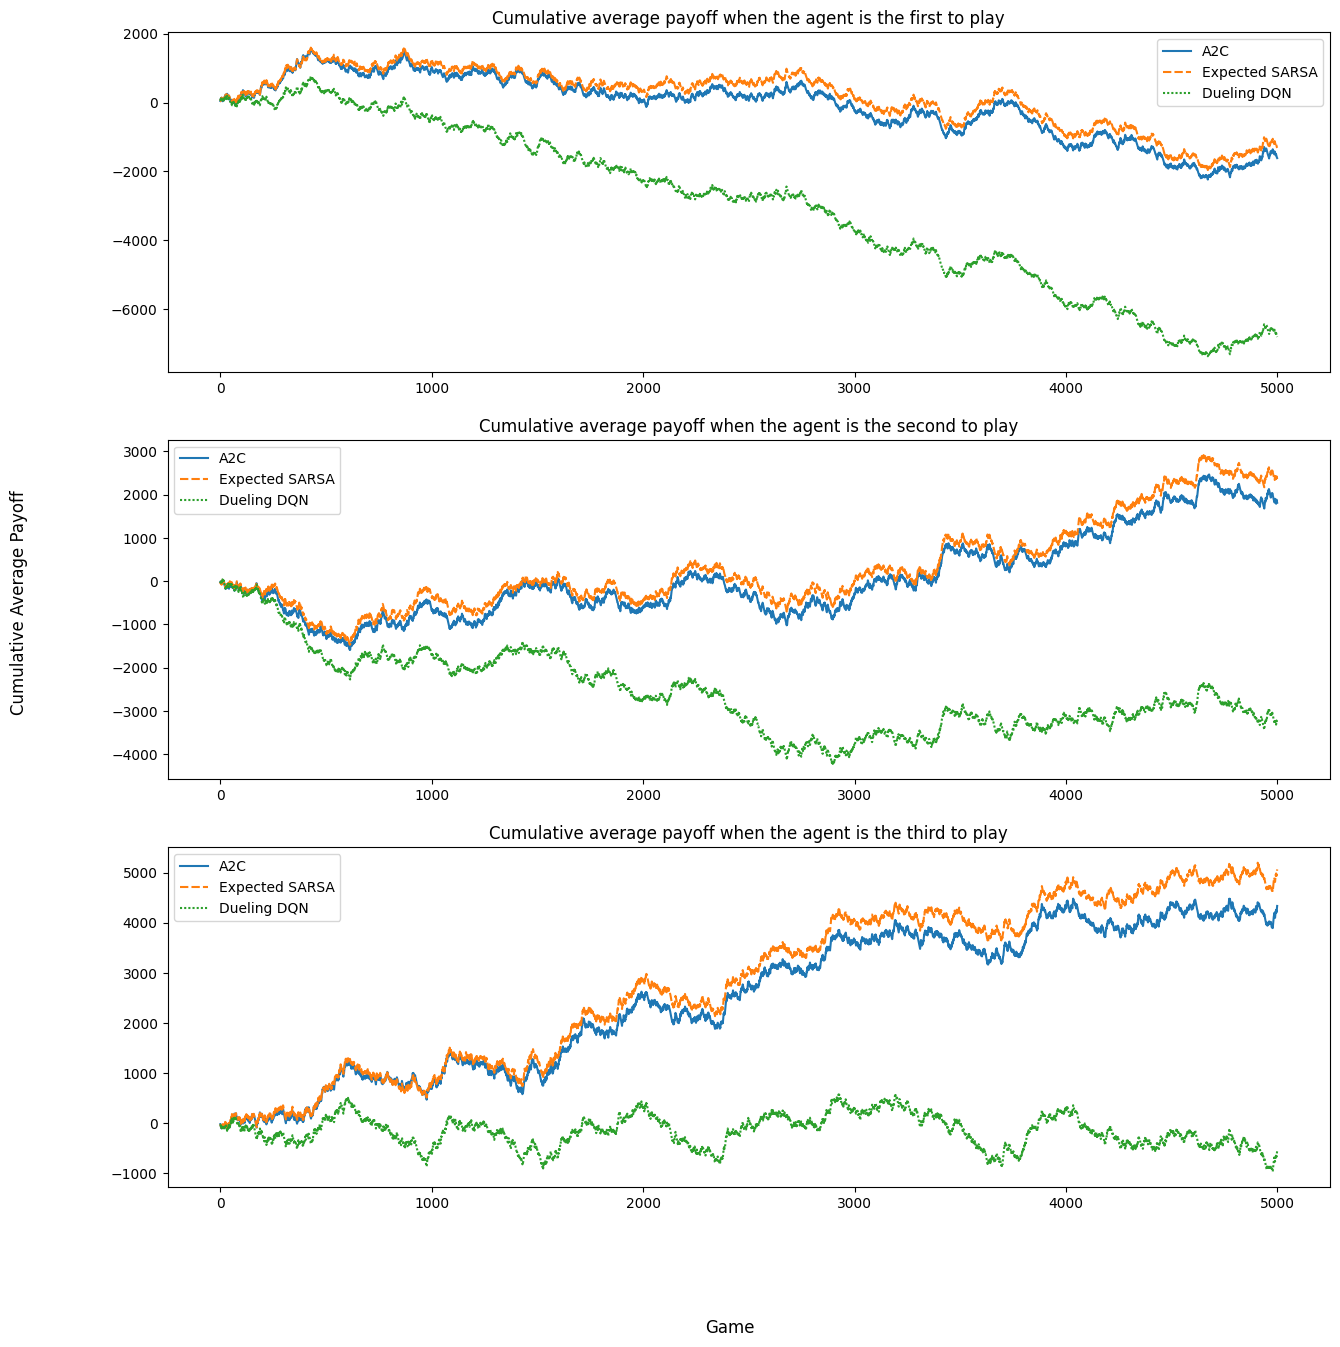

In [ ]:
cum_payoff_plots(agents_ar_eo, ["A2C", "Expected SARSA", "Dueling DQN"])

# Deep Monte-Carlo CFR (Unsuccessful)

This is our unsucessful attempt to implement a Deep Monte-Carlo CFR agent mostly based on [this presentation](https://icml.cc/media/icml-2019/Slides/4443.pdf). We ultimately chose to use the reference CFR implementation from `rlcard`, while keeping this here to demonstrate our thought process.

In [ ]:
class ValueFunctionNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ValueFunctionNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size[0] + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class StrategyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(StrategyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size[0], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))

        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

In [ ]:
class CFRAgent:
    def __init__(self, env, num_actions=2, state_shape=None, learning_rate=0.001):
        """Initilize Agent
        Args:
            env (Env): Env class
        """
        self.use_raw = False
        self.env = env
        self.num_actions = num_actions
        self.state_shape = state_shape

        self.value_net = ValueFunctionNetwork(self.state_shape, self.num_actions, 32)
        self.strategy_net = StrategyNetwork(self.state_shape, self.num_actions, 32)

        self.state_value_targets = []
        self.state_strategy_targets = []
        self.state_inputs = []
        self.action_inputs = []

        for p in self.value_net.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        for p in self.strategy_net.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        self.strategy_optimizer = optim.Adam(
            self.strategy_net.parameters(), lr=learning_rate
        )
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=learning_rate)

    def clear_record(self):
        self.state_value_targets = []
        self.state_strategy_targets = []
        self.state_inputs = []
        self.action_inputs = []

    def train(self):
        for player_id in range(self.env.num_players):
            self.env.reset()
            # probs = np.ones(self.env.num_players)
            self.traverse_tree(player_id)

        self.value_net.train()
        self.value_optimizer.zero_grad()
        value_predictions = self.value_net(
            torch.tensor(self.state_inputs), torch.tensor(self.action_inputs)
        )
        value_loss = nn.MSELoss()(
            value_predictions, torch.tensor(self.state_value_targets)
        )
        value_loss.backward()
        self.value_optimizer.step()

        # Train strategy_net
        self.strategy_net.train()
        self.strategy_optimizer.zero_grad()
        strategy_predictions = self.strategy_net(torch.tensor(self.state_inputs))
        strategy_loss = nn.KLDivLoss()(
            strategy_predictions, torch.tensor(self.state_strategy_targets)
        )
        strategy_loss.backward()
        self.strategy_optimizer.step()
        self.clear_record()

    def action_probs(self, state, length):
        state = torch.tensor(state).float()
        strategy = self.strategy_net(state).detach().numpy()
        strategy = strategy[:length]
        strategy = strategy / strategy.sum()
        return strategy

    def action_encode(self, action):
        if action == 0:
            return np.array([0, 0, 0, 1])
        if action == 1:
            return np.array([0, 0, 1, 0])
        if action == 2:
            return np.array([0, 1, 0, 0])
        if action == 3:
            return np.array([1, 0, 0, 0])

    def traverse_tree(self, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        legal_actions = list(self.env.get_state(current_player)["legal_actions"].keys())
        state = self.env.get_state(current_player)["obs"]
        strategy = self.action_probs(state, len(legal_actions))
        action = np.random.choice(legal_actions, p=strategy)

        # action_prob = strategy[action]
        # new_probs = probs.copy()
        # new_probs[current_player] *= action_prob
        self.env.step(action)
        child_payoff = self.traverse_tree(player_id)
        self.env.step_back()
        action_values = np.zeros(len(legal_actions))

        for i, valid_action in enumerate(legal_actions):
            # print(valid_action)
            encode_action = self.action_encode(valid_action)
            action_value = self.value_net(
                torch.tensor(state).float(), torch.tensor(encode_action).float()
            ).item()
            action_values[i] = action_value

        print(strategy, action_values, (strategy * action_values).sum())
        counterfactual_values = (strategy * action_values).sum()

        for i, valid_action in enumerate(legal_actions):
            # Collect data for value_net
            encode_action = self.action_encode(valid_action)
            self.state_inputs.append(state)
            self.action_inputs.append(encode_action)
            self.state_value_targets.append(
                child_payoff[current_player]
                if valid_action == action
                else counterfactual_values
            )

            # Collect data for strategy_net
            self.state_strategy_targets.append(strategy)
            print(child_payoff)
            print()
            regret = child_payoff[current_player] - counterfactual_values
            if valid_action == action:
                self.state_strategy_targets[-1][i] += regret

        return counterfactual_values